# CNN with Tensorflow: HandSigns dataset application

## Introduction

The assignment #2 at Coursera CNN Course (by Andrew Ng) showed 78.3% classification accuracy for recognizing hand signs data-set provided in the course.

In this notebook, I implemented a simple Convolutional Neural Network in TensorFlow which has a classification accuracy of about >93%. 

My aim was to implement the CNN with a different Tensorflow graph. This code runs quite fast using a low-end GPU. The training data was acquired from the course at well.

by Mehmet Solmaz, https://github.com/mesolmaz

I benefited a lot from Hvass-Labs tensorflow tutorials (like using the Helper functions). Kudos to him: (https://github.com/Hvass-Labs/TensorFlow-Tutorials)




## Imports

In [2]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

%matplotlib inline
np.random.seed(1)

Load the "SIGNS" dataset from current directory. You have to have registered for the course in order to obtain the H5 files.

In [3]:
# Read H5 file
f1 = h5py.File("train_signs.h5", "r")
# Get and print list of datasets within the H5 file
datasetNames = [n for n in f1.keys()]
for n in datasetNames:
    print(n)
    
# Read H5 file
f2 = h5py.File("test_signs.h5", "r")
# Get and print list of datasets within the H5 file
datasetNames = [n for n in f2.keys()]
for n in datasetNames:
    print(n)

list_classes
train_set_x
train_set_y
list_classes
test_set_x
test_set_y


In [4]:
# Loading the Training data (signs)
X_train_orig = np.array(f1['train_set_x'])
print ("Training Data Feature Size = " + str(X_train_orig.shape))
Y_train_orig = np.array(f1['train_set_y'])
print ("Training Data Class Size = " + str(Y_train_orig.shape))

Training Data Feature Size = (1080, 64, 64, 3)
Training Data Class Size = (1080,)


In [5]:
# Loading the Test data (signs)
X_test_orig = np.array(f2['test_set_x'])
print ("Test Data Feature Size = " + str(X_test_orig.shape))
Y_test_orig = np.array(f2['test_set_y'])
print ("Test Data Class Size = " + str(Y_test_orig.shape))

Test Data Feature Size = (120, 64, 64, 3)
Test Data Class Size = (120,)


In [6]:
# How many hand signs (just to make sure, there should be 6)
class_list = np.array(f2['list_classes'])
print ("list_classes = " + str(class_list.shape))

list_classes = (6,)


__The image below was acquired from CNN Course on Coursera.__<br>
The SIGNS dataset is a collection of 6 signs representing numbers from 0 to 5.

<img src="images/SIGNS.png" style="width:800px;height:300px;">


y = 5


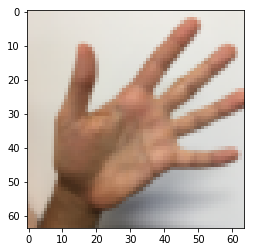

In [7]:
# Example of a picture
index = 29
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[index])))

### Data Wrangling

In [8]:
X_train_orig.dtype
X_train = X_train_orig/255
X_train.dtype

dtype('float64')

In [9]:
#X_train = X_train_orig/255.
X_train = np.divide(X_train_orig,255)
#X_test = X_test_orig/255.
X_test = np.divide(X_test_orig,255)
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [10]:
# We know that SIGNS images are 64 pixels in each dimension.
img_size = 64

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale, 3 for RGB.
num_channels = 3

# Number of classes, total of 6 hand signs.
num_classes = 6

### Helper functions for Weights and Bias initialization3
The functions for Convolution+Pooling+Relu, Flattening layer, and Fully Connected Layer were all obtained from Hvass-Labs.

In [11]:
# Weight Initialization
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(length):
  initial = tf.constant(0.1, shape=[length])
  return tf.Variable(initial)

# Helper-function for creating a new Convolutional Layer
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = weight_variable(shape=shape)

    # Create new biases, one for each filter.
    biases = bias_variable(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

# Helper-function for flattening a layer
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

# Helper-function for creating a new Fully-Connected Layer
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = weight_variable(shape=[num_inputs, num_outputs])
    biases = bias_variable(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

### Create placeholders

TensorFlow requires that you create placeholders for the input data that will be fed into the model when running the session.

In [12]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

#Y = tf.placeholder(tf.float32, shape=[None, 6])
print ("x = " + str(x))
print ("y_true = " + str(y_true))

Instructions for updating:
Use the `axis` argument instead
x = Tensor("x:0", shape=(?, 4096), dtype=float32)
y_true = Tensor("y_true:0", shape=(?, 6), dtype=float32)


### Parameters for CONV1, CONV2 and FC layers

In [13]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

### Create Convolutional Layer 1

In [14]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

In [15]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 32, 32, 16) dtype=float32>

### Create Convolutional Layer 2

In [16]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

In [17]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 16, 16, 36) dtype=float32>

### Create Flatten Layer

In [18]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [19]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 9216) dtype=float32>

In [20]:
num_features

9216

### Create Fully-Connected Layer 1

In [21]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [22]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

### Create Fully-Connected Layer 2

In [23]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [24]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 6) dtype=float32>

### Predicted Class (Softmax)

In [25]:
y_pred = tf.nn.softmax(layer_fc2)

In [26]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

### Cost-function to be optimized

In [27]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,labels=y_true)
cost = tf.reduce_mean(cross_entropy)

### Optimization Method

In [28]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

### Performance Measures

In [29]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [30]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run
### Create TensorFlow session

In [31]:
session = tf.Session()

In [32]:
### Initialize variables
session.run(tf.global_variables_initializer())

### Helper-function to get a random training-batch
There are 1080 images in the training-set. It is a good idea to use small batches of images in each iteration of the optimizer in case you run out of memory.

In [33]:
train_batch_size = 64

In [34]:
def random_batch():
    # Number of images in the training-set.
    num_images = len(X_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = X_train[idx, :, :, :]
    y_batch = Y_train[idx, :]

    return x_batch, y_batch

### Helper-function to perform optimization iterations

In [35]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        # x_batch, y_true_batch = tf.train.batch([X_train, Y_train], batch_size = train_batch_size)
        # x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        x_batch, y_true_batch = random_batch()

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x_image: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### Helper-function to plot example errors

In [36]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    test_true = np.argmax(Y_test, axis=1)
    images = test_true[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test_true.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper-function to plot confusion matrix

In [37]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = np.argmax(Y_test, axis=1)
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for showing the performance

In [38]:
# Split the test-set into smaller batches of this size.
test_batch_size = 16

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(X_test)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = X_test[i:j,:,:,:]

        # Get the associated labels.
        labels = Y_test[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x_image: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = np.argmax(Y_test, axis=1)

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Performance after 2500 optimization iterations

After 2500 optimization iterations, the model has significantly improved its classification accuracy.

In [39]:
optimize(num_iterations=2500)

Optimization Iteration:      1, Training Accuracy:  17.2%
Optimization Iteration:    101, Training Accuracy:  43.8%
Optimization Iteration:    201, Training Accuracy:  59.4%
Optimization Iteration:    301, Training Accuracy:  76.6%
Optimization Iteration:    401, Training Accuracy:  81.2%
Optimization Iteration:    501, Training Accuracy:  90.6%
Optimization Iteration:    601, Training Accuracy:  95.3%
Optimization Iteration:    701, Training Accuracy:  93.8%
Optimization Iteration:    801, Training Accuracy:  95.3%
Optimization Iteration:    901, Training Accuracy:  98.4%
Optimization Iteration:   1001, Training Accuracy:  98.4%
Optimization Iteration:   1101, Training Accuracy:  98.4%
Optimization Iteration:   1201, Training Accuracy:  98.4%
Optimization Iteration:   1301, Training Accuracy: 100.0%
Optimization Iteration:   1401, Training Accuracy: 100.0%
Optimization Iteration:   1501, Training Accuracy: 100.0%
Optimization Iteration:   1601, Training Accuracy: 100.0%
Optimization I

### Test Set Accuracy

Accuracy on Test-Set: 93.3% (112 / 120)
Confusion Matrix:
[[20  0  0  0  0  0]
 [ 0 20  0  0  0  0]
 [ 0  2 17  0  0  1]
 [ 0  0  0 19  0  1]
 [ 0  0  0  1 17  2]
 [ 0  0  0  0  1 19]]


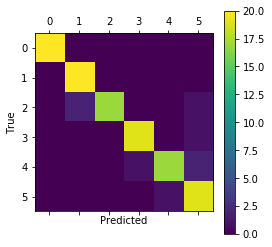

In [40]:
print_test_accuracy(show_confusion_matrix=True)

It looks like we have High Variance (or Overfitting) the Training data. We can solve the Variance Problem using a Drop-out regularization. But I am not implementing that here.